# 1. IMPORTING NECESSARY LIBRARIES


In [54]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from matplotlib.colors import ListedColormap
from sklearn.metrics import precision_score, recall_score, plot_confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn import metrics

# 2. LOADING DATA

In [55]:
data=pd.read_csv(r"C:\Users\utkar\Downloads\spam.csv",encoding='ISO-8859-1')

In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [57]:
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives around here though",NaN,NaN,NaN


##### DROPPING REDUNDANT COLUMNS

In [58]:
dropped_columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4']

In [59]:
data.drop(columns=dropped_columns,inplace=True)

##### RENAMING COLUMNS

In [60]:
data.rename(columns= {"v1":"Target","v2":"Text"},inplace= True) 
data.tail()

,Target,Text
5567,spam,"This is the 2nd time we have tried 2 contact u. U have won the å£750 Pound prize. 2 claim is easy, call 087187272008 NOW1! Only 10p per minute. BT-national-rate."
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other suggestions?"
5570,ham,The guy did some bitching but I acted like i'd be interested in buying something else next week and he gave it to us for free
5571,ham,Rofl. Its true to its name


In [61]:
data.describe()

,Target,Text
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


# 3.EXPLORING THE DATA

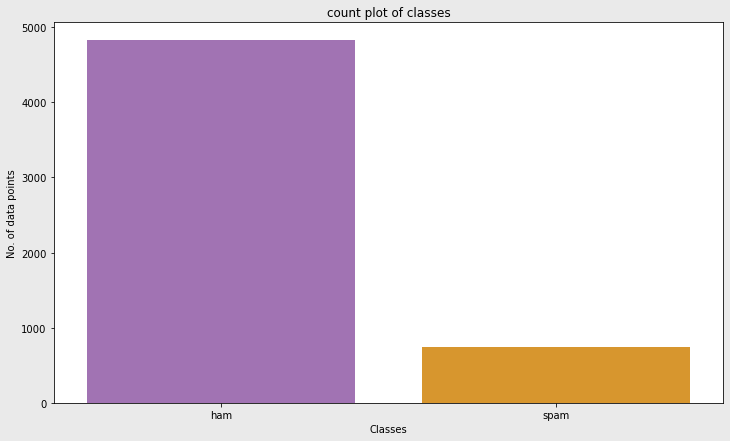

In [62]:
cols=["#A569BD","#F39C12"]
plt.figure(figsize=(12,7), facecolor="#EAEAEA")
fg=sns.countplot(x=data["Target"],palette=cols)
fg.set_title("count plot of classes")
fg.set_xlabel("Classes")
fg.set_ylabel("No. of data points")
plt.show()              

In [63]:
## We can see from the given countplot that dataset isimbalanced

In [64]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\utkar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [65]:
# Creating New variables for Data Exploration

In [66]:
data["No._of_Characters"]=data["Text"].apply(len)

In [67]:
data["No._of_words"]=data.apply(lambda row:nltk.word_tokenize(row["Text"]),axis=1).apply(len)

In [68]:
data["No._of_sentence"]=data.apply(lambda row:nltk.sent_tokenize(row["Text"]),axis=1).apply(len)

In [69]:
data.describe()

,No._of_Characters,No._of_words,No._of_sentence
count,5572.000000,5572.000000,5572.000000
mean,80.118808,18.695621,1.970747
std,59.690841,13.742587,1.417778
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,61.000000,15.000000,1.000000
75%,121.000000,27.000000,2.000000
max,910.000000,220.000000,28.000000


<Figure size 864x504 with 0 Axes>

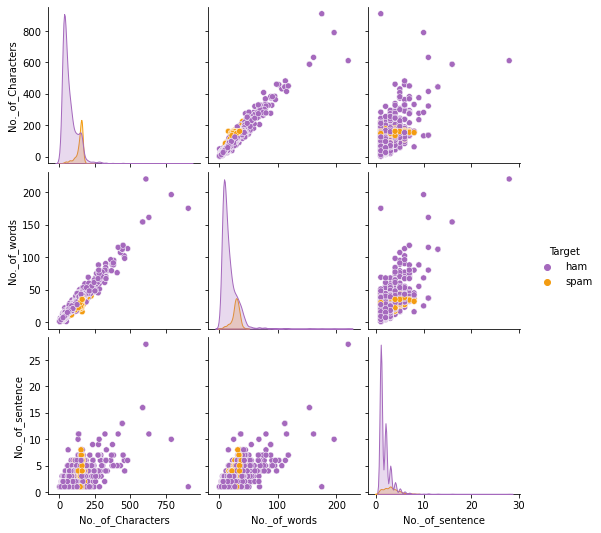

In [70]:
plt.figure(figsize=(12,7))
fig=sns.pairplot(data=data,hue="Target",palette=cols)
plt.show(fig)

In [71]:
filter_data = data[(data["No._of_Characters"]<380)]
filter_data.shape

(5552, 5)

<Figure size 864x504 with 0 Axes>

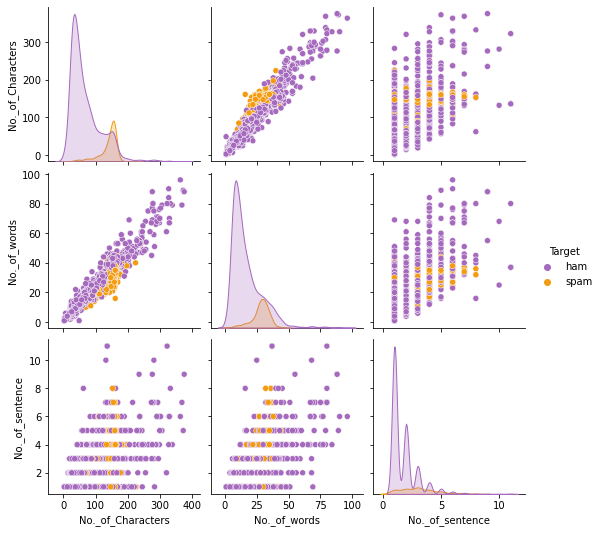

In [72]:
plt.figure(figsize=(12,7))
fig=sns.pairplot(data=filter_data,hue="Target",palette=cols)
plt.show(fig)

# 4. PREPROCESSING

In [73]:
pd.set_option('max_colwidth',None)
filter_data["Text"][:6]

0                                                Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
1                                                                                                                                  Ok lar... Joking wif u oni...
2    Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3                                                                                                              U dun say so early hor... U c already then say...
4                                                                                                  Nah I don't think he goes to usf, he lives around here though
5           FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv
Name: Text, dtype: object

In [74]:
def cleaning(Text):
    cltext=re.sub('[^a-zA-Z]', ' ', Text) # Replace  non alphabetic characters with spaces
    cltext=cltext.lower()
    cltext=cltext.split()
    cltext=" ".join(cltext)
    return cltext

filter_data["Clean_Text"]=filter_data["Text"].apply(cleaning)
pd.set_option('max_colwidth',None)
filter_data["Clean_Text"][:6]
    
    

C:\Users\utkar\AppData\Local\Temp\ipykernel_7808\2050224135.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_data["Clean_Text"]=filter_data["Text"].apply(cleaning)


0                                     go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat
1                                                                                                                    ok lar joking wif u oni
2             free entry in a wkly comp to win fa cup final tkts st may text fa to to receive entry question std txt rate t c s apply over s
3                                                                                                u dun say so early hor u c already then say
4                                                                               nah i don t think he goes to usf he lives around here though
5    freemsg hey there darling it s been week s now and no word back i d like some fun you up for it still tb ok xxx std chgs to send to rcv
Name: Clean_Text, dtype: object

In [75]:
filter_data.head(6)

,Target,Text,No._of_Characters,No._of_words,No._of_sentence,Clean_Text
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",111,24,2,go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat
1,ham,Ok lar... Joking wif u oni...,29,8,2,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,155,37,2,free entry in a wkly comp to win fa cup final tkts st may text fa to to receive entry question std txt rate t c s apply over s
3,ham,U dun say so early hor... U c already then say...,49,13,1,u dun say so early hor u c already then say
4,ham,"Nah I don't think he goes to usf, he lives around here though",61,15,1,nah i don t think he goes to usf he lives around here though
5,spam,"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv",148,39,4,freemsg hey there darling it s been week s now and no word back i d like some fun you up for it still tb ok xxx std chgs to send to rcv


##### TOKENIZATION

###### Tokenization is the process of breaking complex data into smaller units called tokens

In [76]:
def tokenize_text(text):
    return nltk.word_tokenize(text)

filter_data["Tokenize_Text"] = filter_data["Clean_Text"].apply(tokenize_text)

C:\Users\utkar\AppData\Local\Temp\ipykernel_7808\3969822599.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_data["Tokenize_Text"] = filter_data["Clean_Text"].apply(tokenize_text)


In [77]:
filter_data["Tokenize_Text"][:6]

0                                                  [go, until, jurong, point, crazy, available, only, in, bugis, n, great, world, la, e, buffet, cine, there, got, amore, wat]
1                                                                                                                                               [ok, lar, joking, wif, u, oni]
2                [free, entry, in, a, wkly, comp, to, win, fa, cup, final, tkts, st, may, text, fa, to, to, receive, entry, question, std, txt, rate, t, c, s, apply, over, s]
3                                                                                                                      [u, dun, say, so, early, hor, u, c, already, then, say]
4                                                                                                  [nah, i, don, t, think, he, goes, to, usf, he, lives, around, here, though]
5    [freemsg, hey, there, darling, it, s, been, week, s, now, and, no, word, back, i, d, like, some, fun, you, up, for, it, 

##### STOPWORDS REMOVAL

In [78]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\utkar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [79]:
def remove_stopwords(text):
    stop_words = set(stopwords.words("english"))
    filtered_text = [word for word in text if word not in stop_words]
    return filtered_text

filter_data["Nostopword_Text"] = filter_data["Tokenize_Text"].apply(remove_stopwords)

C:\Users\utkar\AppData\Local\Temp\ipykernel_7808\3064888077.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_data["Nostopword_Text"] = filter_data["Tokenize_Text"].apply(remove_stopwords)


In [80]:
filter_data["Nostopword_Text"][:6]

0                            [go, jurong, point, crazy, available, bugis, n, great, world, la, e, buffet, cine, got, amore, wat]
1                                                                                                 [ok, lar, joking, wif, u, oni]
2    [free, entry, wkly, comp, win, fa, cup, final, tkts, st, may, text, fa, receive, entry, question, std, txt, rate, c, apply]
3                                                                                  [u, dun, say, early, hor, u, c, already, say]
4                                                                                 [nah, think, goes, usf, lives, around, though]
5                                 [freemsg, hey, darling, week, word, back, like, fun, still, tb, ok, xxx, std, chgs, send, rcv]
Name: Nostopword_Text, dtype: object

In [28]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\utkar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\utkar\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

##### LEMMATIZATION

In [81]:
lemmatizer=WordNetLemmatizer()

In [82]:
def lemmatize_word(text):
    lemmatization=[lemmatizer.lemmatize(word,pos='v') for word in text]
    return lemmatization
filter_data["Lemmatized_Text"]=filter_data["Nostopword_Text"].apply(lemmatize_word)

C:\Users\utkar\AppData\Local\Temp\ipykernel_7808\372578560.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_data["Lemmatized_Text"]=filter_data["Nostopword_Text"].apply(lemmatize_word)


In [83]:
filter_data["Lemmatized_Text"][:6]

0                            [go, jurong, point, crazy, available, bugis, n, great, world, la, e, buffet, cine, get, amore, wat]
1                                                                                                   [ok, lar, joke, wif, u, oni]
2    [free, entry, wkly, comp, win, fa, cup, final, tkts, st, may, text, fa, receive, entry, question, std, txt, rate, c, apply]
3                                                                                  [u, dun, say, early, hor, u, c, already, say]
4                                                                                    [nah, think, go, usf, live, around, though]
5                                 [freemsg, hey, darling, week, word, back, like, fun, still, tb, ok, xxx, std, chgs, send, rcv]
Name: Lemmatized_Text, dtype: object

# 5. VECTORIZATION

In [86]:
# Creating a corpus of Text
corpus=[]
for i in filter_data["Lemmatized_Text"]:
    txt=' '.join([row for row in i])
    corpus.append(txt)
    
corpus[:6]    
    

['go jurong point crazy available bugis n great world la e buffet cine get amore wat',
 'ok lar joke wif u oni',
 'free entry wkly comp win fa cup final tkts st may text fa receive entry question std txt rate c apply',
 'u dun say early hor u c already say',
 'nah think go usf live around though',
 'freemsg hey darling week word back like fun still tb ok xxx std chgs send rcv']

In [87]:
#Changing to numerical
tfidf=TfidfVectorizer()
x=tfidf.fit_transform(corpus).toarray()

In [88]:
#Encoding the taget variable
label_encoder = LabelEncoder()
filter_data["Target"] = label_encoder.fit_transform(filter_data["Target"])

C:\Users\utkar\AppData\Local\Temp\ipykernel_7808\489826115.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_data["Target"] = label_encoder.fit_transform(filter_data["Target"])


In [89]:
filter_data["Target"][:6]

0    0
1    0
2    1
3    0
4    0
5    1
Name: Target, dtype: int64

# 6. MODEL BUILDING

<b> Prepare Data:</b>
Define features (X) and target (y).
    
<b> Data Splitting:</b>
Split data into training and testing sets
    
<b> Model Pipelines:</b>
Build pipelines for:
Naïve Bayes,
RandomForestClassifier,
KNeighborsClassifier and
Support Vector Machines (SVM)
    
<b> Model Training:</b>
Fit each model on the training data
    
<b> Cross-Validation:</b>
Perform k-fold cross-validation for accuracy assessment.

<b> Results:</b>
Evaluate model performances and choose the best.





In [90]:
# Setting the values for labels as y and feature as x
y=filter_data["Target"]
#Splitting and training data
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25,random_state=42)

In [91]:
# Classifiers to be Tested
classifiers=[MultinomialNB(),
             RandomForestClassifier(),
             KNeighborsClassifier(),
             SVC()]
for classifier in classifiers:
    classifier.fit(x_train,y_train)

In [92]:
pipe_dict={0:"NaiveBayes",1:"RandomForest",2:"Kneighbours",3:"SVC"}

In [93]:
#cross validation
for i,model in enumerate(classifiers):
    cv_score=cross_val_score(model,x_train,y_train,scoring="accuracy",cv=8)
    print("%s: %f " % (pipe_dict[i], cv_score.mean()))

NaiveBayes: 0.964457 
RandomForest: 0.974305 
Kneighbours: 0.911862 
SVC: 0.972621 


# 7. MODEL EVALUATION
Testing the model on test Data
<ul>
    <li> Accuracy Report</li>
    <li> Confusion Matrix</li>
</ul>
     

In [106]:
# Model Evaluation
# Lists of various Scores
precision=[]
recall=[]
f1_score=[]
trainset_accuracy=[]
testset_accuracy=[]
for i in classifiers:
    pred_train=i.predict(x_train)
    pred_test=i.predict(x_test)
    prec=metrics.precision_score(y_test,pred_test)
    recal=metrics.recall_score(y_test,pred_test)
    f1_s=metrics.f1_score(y_test,pred_test)
    train_accuracy=model.score(x_train,y_train)
    test_accuracy=model.score(x_test,y_test)
    precision.append(prec)
    recall.append(recal)
    f1_score.append(f1_s)
    trainset_accuracy.append(train_accuracy)
    testset_accuracy.append(test_accuracy)
    
    
    

In [107]:
new_data={'Precision':precision,
      'Recall':recall,
      'F1Score':f1_score,
      'Accuracy on TestData':testset_accuracy,
      'Accuracy on TrainData':trainset_accuracy}
#Creating Dataframe for tabular representation
Results = pd.DataFrame(new_data, index =["NaiveBayes", "RandomForest", "KNeighbours","SVC"])

In [113]:
cmap2 = ListedColormap(["#A9CCE3", "#BB8FCE"])  # Blue and Purple shades
Results.style.background_gradient(cmap=cmap2)


,Precision,Recall,F1Score,Accuracy on TestData,Accuracy on TrainData
NaiveBayes,0.986842,0.738916,0.845070,0.971182,0.997118
RandomForest,1.000000,0.842365,0.914439,0.971182,0.997118
KNeighbours,1.000000,0.339901,0.507353,0.971182,0.997118
SVC,0.993939,0.807882,0.891304,0.971182,0.997118


C:\Users\utkar\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\utkar\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\utkar\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods:

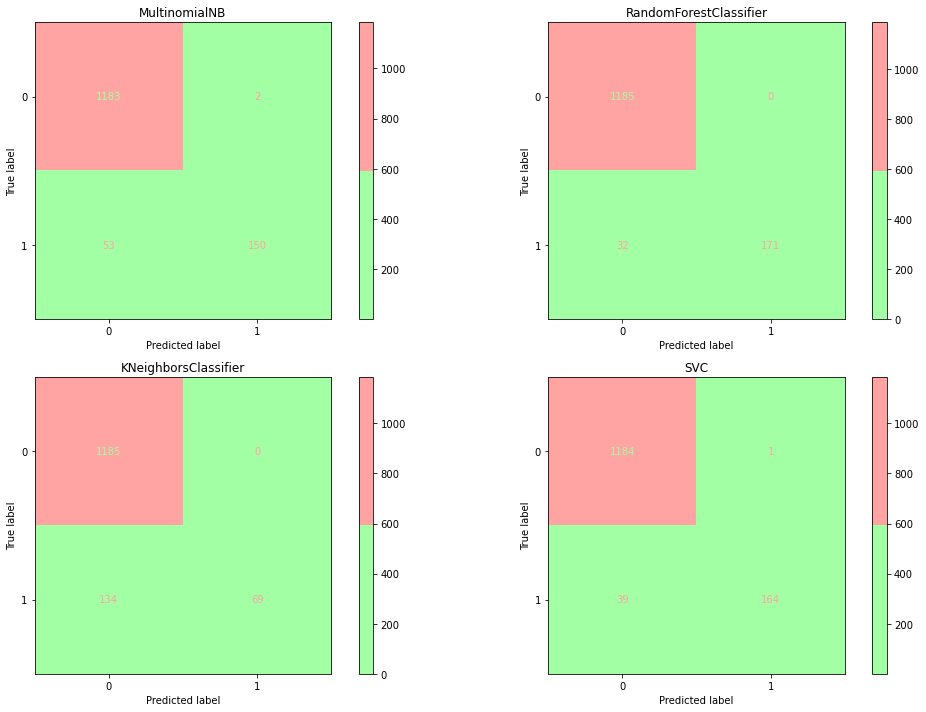

In [117]:
cmap = ListedColormap(["#A3FFA3", "#FFA3A3"])  # Light Green and Light Red shades
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

for cls, ax in zip(classifiers, axes.flatten()):
    plot_confusion_matrix(cls, 
                          x_test, 
                          y_test, 
                          ax=ax, 
                          cmap=cmap
                          )
    ax.title.set_text(type(cls).__name__)
plt.tight_layout()  
plt.show()
